In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
pd.options.mode.chained_assignment = None  # default='warn'
import yfinance as yf

In [271]:
ticker = 'BTC-USD'
dataframe = yf.download(ticker)
#dataframe.index=dataframe['Date']
#df.drop("Date",axis=1,inplace=True)

[*********************100%***********************]  1 of 1 completed


In [28]:
def create_feature_ROC(df, n_period = 10):
    df['ROC'] = np.nan
    for i in range (n_period, len(df)):
        df['ROC'][i] = (df['Close'][i] - df['Close'][i-n_period])/df['Close'][i-n_period]*100
    return df

In [65]:
def LSTM_prediction(df, split_ratio = 0.7, ROC = False, n_period = 10, epochs = 40, batch_size = 32, units = 50):
    target = ['Close']
    features = []
    if ROC:
        features.append('ROC')
        df = create_feature_ROC(df, n_period)
    
    df = df[target + features]
    
    # remove na
    df = df.dropna()
    
    # split data
    split = int(df.shape[0]*split_ratio)
    train = df.iloc[:split, :].copy()
    test = df.iloc[split:, :].copy()
    
    # scale data
    target_scaler = MinMaxScaler().fit(train[target])
    train[target] = target_scaler.transform(train[target])
    test[target] = target_scaler.transform(test[target])
    
    if features:
        features_scaler = MinMaxScaler().fit(train[features])
        train[features] = features_scaler.transform(train[features])
        test[features] = features_scaler.transform(test[features])
    
    # input sequence length
    sequence_length = 30
    
    x_train, y_train = [], []
    
    for i in range (sequence_length, train.shape[0]):
        x_train.append(train[features + target].iloc[i - sequence_length: i])
        y_train.append(train[target].iloc[i])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test, y_test = [], []
    
    for i in range(sequence_length, test.shape[0]):
        x_test.append(test[features + target].iloc[i - sequence_length: i])
        y_test.append(test[target].iloc[i])

    x_test, y_test = np.array(x_test), np.array(y_test)
    
    # build and train model
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

    model.evaluate(x_test, y_test)
    
    # generate the test set predictions
    y_pred = model.predict(x_test)
    y_pred = target_scaler.inverse_transform(y_pred)
    
    # add predicted values
    df['Predicted Close'] = np.nan
    df['Predicted Close'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
    
    return df

In [82]:
def RNN_prediction(df, split_ratio = 0.7, ROC = False, n_period = 10, epochs = 40, batch_size = 32, units = 50):
    target = ['Close']
    features = []
    if ROC:
        features.append('ROC')
        df = create_feature_ROC(df, n_period)
    
    df = df[target + features]
    
    # remove na
    df = df.dropna()
    
    # split data
    split = int(df.shape[0]*split_ratio)
    train = df.iloc[:split, :].copy()
    test = df.iloc[split:, :].copy()
    
    # scale data
    target_scaler = MinMaxScaler().fit(train[target])
    train[target] = target_scaler.transform(train[target])
    test[target] = target_scaler.transform(test[target])
    
    if features:
        features_scaler = MinMaxScaler().fit(train[features])
        train[features] = features_scaler.transform(train[features])
        test[features] = features_scaler.transform(test[features])
    
    # input sequence length
    sequence_length = 30
    
    x_train, y_train = [], []
    
    for i in range (sequence_length, train.shape[0]):
        x_train.append(train[features + target].iloc[i - sequence_length: i])
        y_train.append(train[target].iloc[i])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test, y_test = [], []
    
    for i in range(sequence_length, test.shape[0]):
        x_test.append(test[features + target].iloc[i - sequence_length: i])
        y_test.append(test[target].iloc[i])

    x_test, y_test = np.array(x_test), np.array(y_test)
    
    # build and train model
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=False, input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

    model.evaluate(x_test, y_test)
    
    # generate the test set predictions
    y_pred = model.predict(x_test)
    y_pred = target_scaler.inverse_transform(y_pred)
    
    # add predicted values
    df['Predicted Close'] = np.nan
    df['Predicted Close'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
    
    return df

In [273]:
def XGBoost_prediction(df, split_ratio = 0.7, ROC = False, n_period = 10, learning_rate = 0.2):
    target = ['Close']
    features = ['Adj Close']
    if ROC:
        features.append('ROC')
        df = create_feature_ROC(df, n_period)
    
    df = df[target + features]
    
    df['EMA_9'] = df['Close'].ewm(9).mean().shift()
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_10'] = df['Close'].rolling(10).mean().shift()
    df['SMA_15'] = df['Close'].rolling(15).mean().shift()
    df['SMA_30'] = df['Close'].rolling(30).mean().shift()
    
    features = features + ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30',]
    
    # remove na
    df = df.dropna()
    
    # split data
    split = int(df.shape[0]*split_ratio)
    train = df.iloc[:split, :].copy()
    test = df.iloc[split:, :].copy()
    
    x_train = train[features].copy()
    y_train = train[target].copy()
    
    x_test = test[features].copy()
    y_test = test[target].copy()
    
    # build and train model
    eval_set = [(x_train, y_train), (x_test, y_test)]
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=learning_rate, max_depth=10, min_child_weight=1, objective='reg:squarederror')
    model.fit(x_train, y_train, eval_set=eval_set, verbose=100)

    # generate the test set predictions
    y_pred = model.predict(x_test)
    
    # add predicted values
    df['Predicted Close'] = np.nan
    df['Predicted Close'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
    
    return df

In [274]:
df = XGBoost_prediction(dataframe, split_ratio=0.9, ROC=False, learning_rate=0.3)

[0]	validation_0-rmse:14667.93932	validation_1-rmse:15677.07363
[100]	validation_0-rmse:4.54046	validation_1-rmse:242.03312
[200]	validation_0-rmse:0.96409	validation_1-rmse:241.99639
[300]	validation_0-rmse:0.28542	validation_1-rmse:241.97815
[400]	validation_0-rmse:0.08219	validation_1-rmse:241.96470
[500]	validation_0-rmse:0.02864	validation_1-rmse:241.96305
[600]	validation_0-rmse:0.01850	validation_1-rmse:241.96304
[700]	validation_0-rmse:0.01850	validation_1-rmse:241.96304
[800]	validation_0-rmse:0.01850	validation_1-rmse:241.96304
[900]	validation_0-rmse:0.01850	validation_1-rmse:241.96304
[999]	validation_0-rmse:0.01850	validation_1-rmse:241.96304


<Axes: xlabel='Date'>

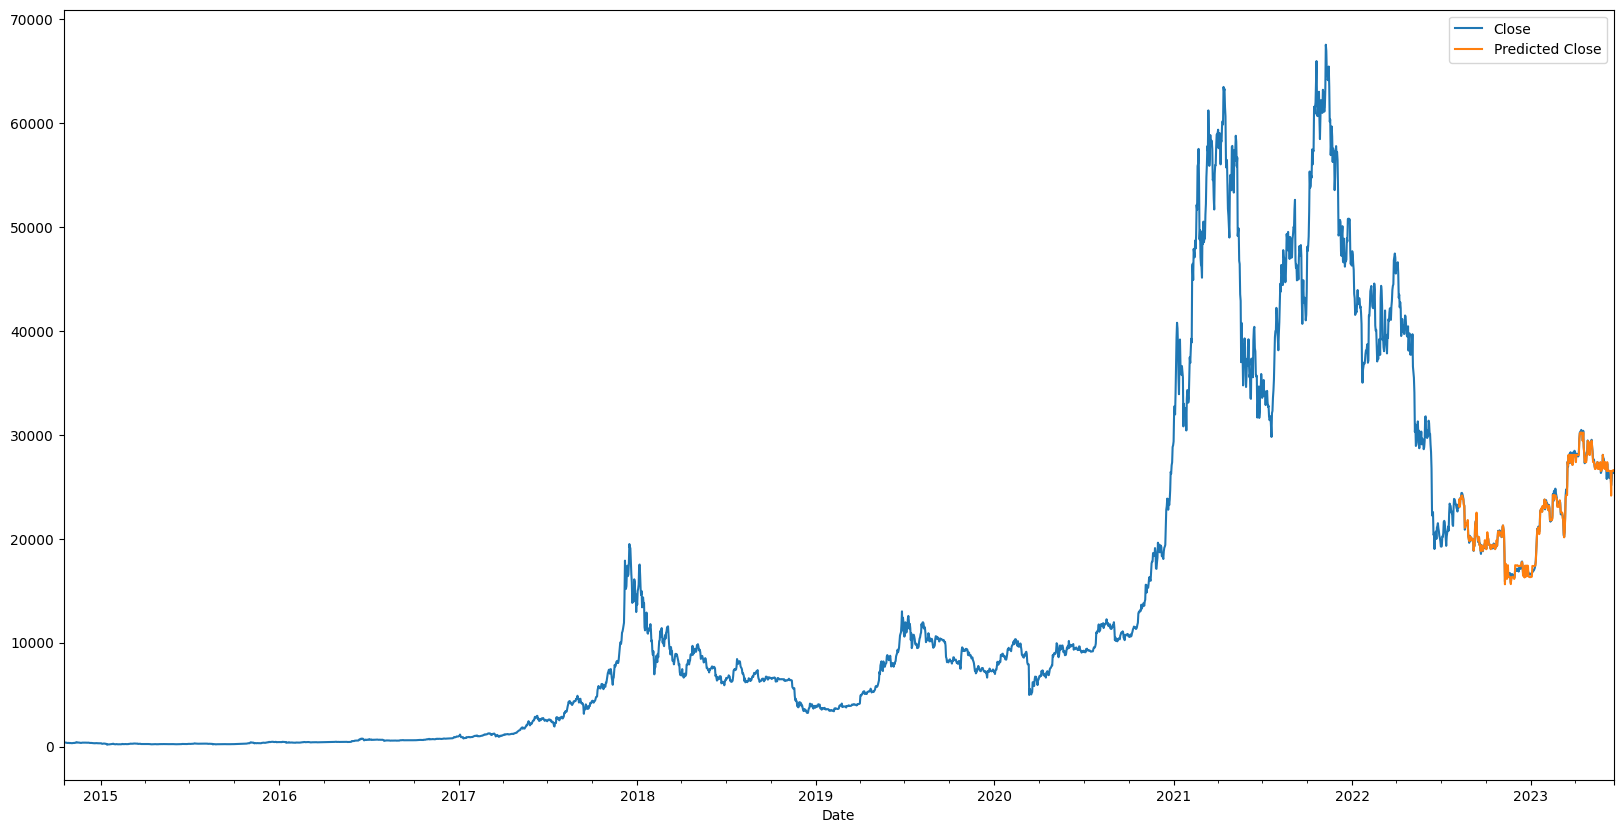

In [275]:
df[['Close', 'Predicted Close']].plot()